## Lab 2
### Part 2: Dealing with overfitting

Today we work with [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) (*hint: it is available in `torchvision`*).

Your goal for today:
1. Train a FC (fully-connected) network that achieves >= 0.885 test accuracy.
2. Cause considerable overfitting by modifying the network (e.g. increasing the number of network parameters and/or layers) and demonstrate in in the appropriate way (e.g. plot loss and accurasy on train and validation set w.r.t. network complexity).
3. Try to deal with overfitting (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

__Please, write a small report describing your ideas, tries and achieved results in the end of this file.__

*Note*: Tasks 2 and 3 are interrelated, in task 3 your goal is to make the network from task 2 less prone to overfitting. Task 1 is independent from 2 and 3.

*Note 2*: We recomment to use Google Colab or other machine with GPU acceleration.

In [2]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchsummary
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

C:\Users\adavydov\AppData\Local\miniconda3\envs\jupyterlab\Lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] Не найдена указанная процедура'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [3]:
device

'cpu'

In [4]:
# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print('Directory', path, 'is created!')
    else:
        print('Directory', path, 'already exists!')

root_path = 'fmnist'
mkdir(root_path)

Directory fmnist already exists!


In [5]:
download = True
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()
transforms.Compose((transforms.ToTensor()))


fmnist_dataset_train = torchvision.datasets.FashionMNIST(root_path,
                                                        train=True,
                                                        transform=train_transform,
                                                        target_transform=None,
                                                        download=download)
fmnist_dataset_test = torchvision.datasets.FashionMNIST(root_path,
                                                       train=False,
                                                       transform=test_transform,
                                                       target_transform=None,
                                                       download=download)

In [6]:
train_loader = torch.utils.data.DataLoader(fmnist_dataset_train,
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)
test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=256,
                                          shuffle=False,
                                          num_workers=2)

In [7]:
len(fmnist_dataset_test)

10000

In [8]:
for img, label in train_loader:
    print(img.shape)
#     print(img)
    print(label.shape)
    print(label.size(0))
    break

torch.Size([128, 1, 28, 28])
torch.Size([128])
128


### Task 1
Train a network that achieves $\geq 0.885$ test accuracy. It's fine to use only Linear (`nn.Linear`) layers and activations/dropout/batchnorm. Convolutional layers might be a great use, but we will meet them a bit later.

In [9]:
class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.BatchNorm1d(input_shape),
            nn.Linear(input_shape, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout1d(p=0.5),
            nn.Linear(256, 128),
            nn.Softplus(),
            nn.BatchNorm1d(128),
            nn.Dropout1d(p=0.25),
            nn.Linear(128, num_classes),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, inp):
        out = self.model(inp)
        return out

In [10]:
torchsummary.summary(TinyNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
       BatchNorm1d-2                  [-1, 784]           1,568
            Linear-3                  [-1, 256]         200,960
              ReLU-4                  [-1, 256]               0
       BatchNorm1d-5                  [-1, 256]             512
         Dropout1d-6                  [-1, 256]               0
            Linear-7                  [-1, 128]          32,896
          Softplus-8                  [-1, 128]               0
       BatchNorm1d-9                  [-1, 128]             256
        Dropout1d-10                  [-1, 128]               0
           Linear-11                   [-1, 10]           1,290
       LogSoftmax-12                   [-1, 10]               0
Total params: 237,482
Trainable params: 237,482
Non-trainable params: 0
-------------------------------

Your experiments come here:

In [11]:
model = TinyNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.NLLLoss()

def train_and_test(model, train_data, test_data, num_epochs):
    def test(data):
        model.eval()
        loss = 0
        total = 0
        correct = 0
        for test, test_target in data:
            test, test_target = test.to(device), test_target.to(device)
            output = model.forward(test)
            loss += loss_func(output, test_target)
            predictions = torch.max(output, 1)[1].to(device)
            correct += (predictions == test_target).sum()
            total += len(test_target)
        accuracy = correct / total
        loss = loss / len(data)
        return loss, accuracy

    test_loss = []
    test_acc = []
    train_loss = []
    train_acc = []
    for epoch in range(1, num_epochs + 1):
        model.train()
        for train, train_target in train_data:
            opt.zero_grad()
            train, train_target = train.to(device), train_target.to(device)
            output = model.forward(train)
            loss = loss_func(output, train_target)
            loss.backward()
            opt.step()
        loss_temp, acc_temp = test(train_data)
        train_loss.append(loss_temp)
        train_acc.append(acc_temp)
        loss_temp, acc_temp = test(test_data)
        test_loss.append(loss_temp)
        test_acc.append(acc_temp)
        print(f"Epoch: {epoch}, Mean training loss: {train_loss[-1]:.3f}, Test accuracy: {test_acc[-1]:.4f}")
    return test_loss, train_loss, test_acc, train_acc

In [11]:
test_loss, train_loss, test_acc, train_acc = train_and_test(model, train_loader, test_loader, num_epochs=20)

Epoch: 1, Mean training loss: 0.691, Test accuracy: 0.8447
Epoch: 2, Mean training loss: 0.636, Test accuracy: 0.8494
Epoch: 3, Mean training loss: 0.597, Test accuracy: 0.8545
Epoch: 4, Mean training loss: 0.601, Test accuracy: 0.8672
Epoch: 5, Mean training loss: 0.558, Test accuracy: 0.8687
Epoch: 6, Mean training loss: 0.498, Test accuracy: 0.8776
Epoch: 7, Mean training loss: 0.547, Test accuracy: 0.8595
Epoch: 8, Mean training loss: 0.478, Test accuracy: 0.8728
Epoch: 9, Mean training loss: 0.455, Test accuracy: 0.8747
Epoch: 10, Mean training loss: 0.430, Test accuracy: 0.8812
Epoch: 11, Mean training loss: 0.445, Test accuracy: 0.8771
Epoch: 12, Mean training loss: 0.412, Test accuracy: 0.8813
Epoch: 13, Mean training loss: 0.371, Test accuracy: 0.8819
Epoch: 14, Mean training loss: 0.388, Test accuracy: 0.8808
Epoch: 15, Mean training loss: 0.363, Test accuracy: 0.8840
Epoch: 16, Mean training loss: 0.340, Test accuracy: 0.8906
Epoch: 17, Mean training loss: 0.351, Test accura

In [12]:
test_loss_cpu = torch.tensor(test_loss, device = 'cpu')
train_loss_cpu = torch.tensor(train_loss, device = 'cpu')
test_acc_cpu = torch.tensor(test_acc, device = 'cpu')
train_acc_cpu = torch.tensor(train_acc, device = 'cpu')

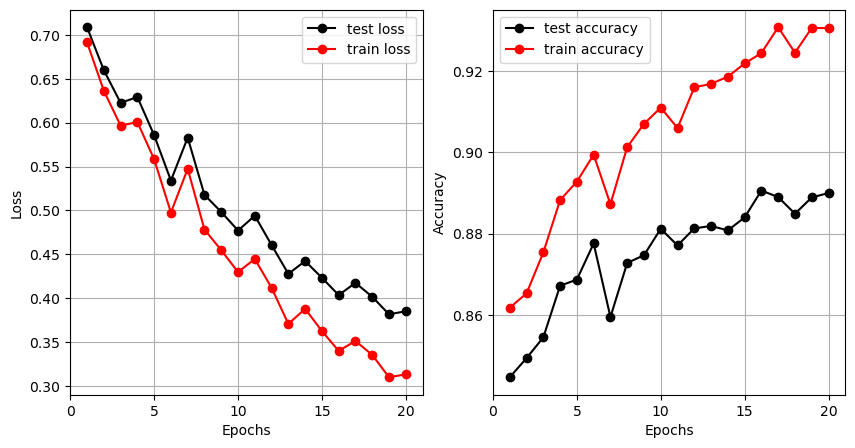

In [13]:
epochs = list(range(1,21))
fig = figure(figsize=(10,5))
ax = fig.subplots(nrows=1, ncols=2)
ax[0].plot(epochs, test_loss_cpu, 'k', marker='o', label="test loss")
ax[0].plot(epochs, train_loss_cpu, 'r', marker='o', label="train loss")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")
ax[0].set_xlim(0, 21)
ax[0].grid()
ax[0].legend()
ax[1].plot(epochs, test_acc_cpu, 'k', marker='o', label="test accuracy")
ax[1].plot(epochs, train_acc_cpu, 'r', marker='o', label="train accuracy")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")
ax[1].set_xlim(0, 21)
ax[1].legend()
ax[1].grid()
plt.show()

It was found that higher value of Dropout parameter for layers with a lot of parameters gives better result for testing accuracy. So, I decided to decrease the Dropout parameter from 0.5 for 256 parameters to 0.25 for 128 parameters. This does the job.

As we see from the above plots, our model performs with the desired higher than 0.885 accuracy on the test dataset without huge overfitting.

### Task 2: Overfit it.
Build a network that will overfit to this dataset. Demonstrate the overfitting in the appropriate way (e.g. plot loss and accurasy on train and test set w.r.t. network complexity).

*Note:* you also might decrease the size of `train` dataset to enforce the overfitting and speed up the computations.

In [14]:
class OverfittingNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_shape, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, inp):
        out = self.model(inp)
        return out

In [15]:
torchsummary.summary(OverfittingNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                 [-1, 1024]         803,840
              ReLU-3                 [-1, 1024]               0
            Linear-4                  [-1, 512]         524,800
              ReLU-5                  [-1, 512]               0
            Linear-6                  [-1, 128]          65,664
              ReLU-7                  [-1, 128]               0
            Linear-8                   [-1, 64]           8,256
              ReLU-9                   [-1, 64]               0
           Linear-10                   [-1, 10]             650
       LogSoftmax-11                   [-1, 10]               0
Total params: 1,403,210
Trainable params: 1,403,210
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forw

In [16]:
model = OverfittingNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.NLLLoss()

In [17]:
test_loss_of, train_loss_of, test_acc_of, train_acc_of = train_and_test(model, train_loader, test_loader, num_epochs=20)

Epoch: 1, Mean training loss: 0.384, Test accuracy: 0.8459
Epoch: 2, Mean training loss: 0.341, Test accuracy: 0.8592
Epoch: 3, Mean training loss: 0.304, Test accuracy: 0.8692
Epoch: 4, Mean training loss: 0.287, Test accuracy: 0.8690
Epoch: 5, Mean training loss: 0.275, Test accuracy: 0.8759
Epoch: 6, Mean training loss: 0.247, Test accuracy: 0.8839
Epoch: 7, Mean training loss: 0.232, Test accuracy: 0.8885
Epoch: 8, Mean training loss: 0.225, Test accuracy: 0.8860
Epoch: 9, Mean training loss: 0.234, Test accuracy: 0.8816
Epoch: 10, Mean training loss: 0.202, Test accuracy: 0.8901
Epoch: 11, Mean training loss: 0.196, Test accuracy: 0.8937
Epoch: 12, Mean training loss: 0.199, Test accuracy: 0.8914
Epoch: 13, Mean training loss: 0.194, Test accuracy: 0.8875
Epoch: 14, Mean training loss: 0.170, Test accuracy: 0.8936
Epoch: 15, Mean training loss: 0.174, Test accuracy: 0.8907
Epoch: 16, Mean training loss: 0.162, Test accuracy: 0.8890
Epoch: 17, Mean training loss: 0.148, Test accura

In [18]:
test_loss_of_cpu = torch.tensor(test_loss_of, device = 'cpu')
train_loss_of_cpu = torch.tensor(train_loss_of, device = 'cpu')
test_acc_of_cpu = torch.tensor(test_acc_of, device = 'cpu')
train_acc_of_cpu = torch.tensor(train_acc_of, device = 'cpu')

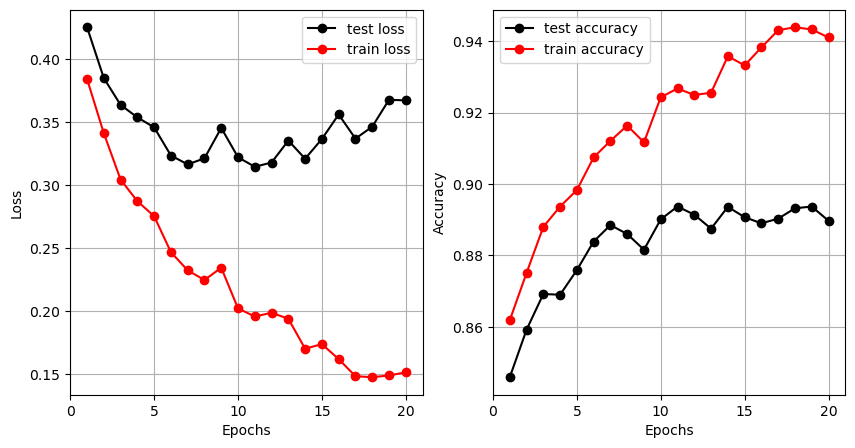

In [19]:
epochs = list(range(1,21))
fig = figure(figsize=(10,5))
ax = fig.subplots(nrows=1, ncols=2)
ax[0].plot(epochs, test_loss_of_cpu, 'k', marker='o', label="test loss")
ax[0].plot(epochs, train_loss_of_cpu, 'r', marker='o', label="train loss")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")
ax[0].set_xlim(0, 21)
ax[0].grid()
ax[0].legend()
ax[1].plot(epochs, test_acc_of_cpu, 'k', marker='o', label="test accuracy")
ax[1].plot(epochs, train_acc_of_cpu, 'r', marker='o', label="train accuracy")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")
ax[1].set_xlim(0, 21)
ax[1].legend()
ax[1].grid()
plt.show()

I decided to manually increase the number of parameters of the initial layer from 28*28 to 1024 and add more hidden layers, increasing the number of network parameters. The loss plot shows that we have clear huge overfitting.

### Task 3: Fix it.
Fix the overfitted network from the previous step (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

In [20]:
class FixedNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.BatchNorm1d(input_shape),
            nn.Linear(input_shape, 1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024),
            nn.Dropout1d(p=0.5),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout1d(p=0.2),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Linear(64, num_classes),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, inp):
        out = self.model(inp)
        return out

In [21]:
torchsummary.summary(FixedNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
       BatchNorm1d-2                  [-1, 784]           1,568
            Linear-3                 [-1, 1024]         803,840
              ReLU-4                 [-1, 1024]               0
       BatchNorm1d-5                 [-1, 1024]           2,048
         Dropout1d-6                 [-1, 1024]               0
            Linear-7                  [-1, 512]         524,800
              ReLU-8                  [-1, 512]               0
       BatchNorm1d-9                  [-1, 512]           1,024
        Dropout1d-10                  [-1, 512]               0
           Linear-11                  [-1, 128]          65,664
             ReLU-12                  [-1, 128]               0
      BatchNorm1d-13                  [-1, 128]             256
           Linear-14                   

In [22]:
model = FixedNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.NLLLoss()

In [23]:
test_loss_of_fixed, train_loss_of_fixed, test_acc_of_fixed, train_acc_of_fixed = train_and_test(model, train_loader, test_loader, num_epochs=20)

Epoch: 1, Mean training loss: 0.835, Test accuracy: 0.8101
Epoch: 2, Mean training loss: 0.754, Test accuracy: 0.8481
Epoch: 3, Mean training loss: 0.740, Test accuracy: 0.8583
Epoch: 4, Mean training loss: 0.714, Test accuracy: 0.8573
Epoch: 5, Mean training loss: 0.637, Test accuracy: 0.8664
Epoch: 6, Mean training loss: 0.648, Test accuracy: 0.8712
Epoch: 7, Mean training loss: 0.608, Test accuracy: 0.8760
Epoch: 8, Mean training loss: 0.584, Test accuracy: 0.8672
Epoch: 9, Mean training loss: 0.570, Test accuracy: 0.8796
Epoch: 10, Mean training loss: 0.570, Test accuracy: 0.8704
Epoch: 11, Mean training loss: 0.537, Test accuracy: 0.8829
Epoch: 12, Mean training loss: 0.497, Test accuracy: 0.8746
Epoch: 13, Mean training loss: 0.475, Test accuracy: 0.8883
Epoch: 14, Mean training loss: 0.473, Test accuracy: 0.8853
Epoch: 15, Mean training loss: 0.457, Test accuracy: 0.8895
Epoch: 16, Mean training loss: 0.449, Test accuracy: 0.8934
Epoch: 17, Mean training loss: 0.433, Test accura

In [24]:
test_loss_of_fixed_cpu = torch.tensor(test_loss_of_fixed, device = 'cpu')
train_loss_of_fixed_cpu = torch.tensor(train_loss_of_fixed, device = 'cpu')
test_acc_of_fixed_cpu = torch.tensor(test_acc_of_fixed, device = 'cpu')
train_acc_of_fixed_cpu = torch.tensor(train_acc_of_fixed, device = 'cpu')

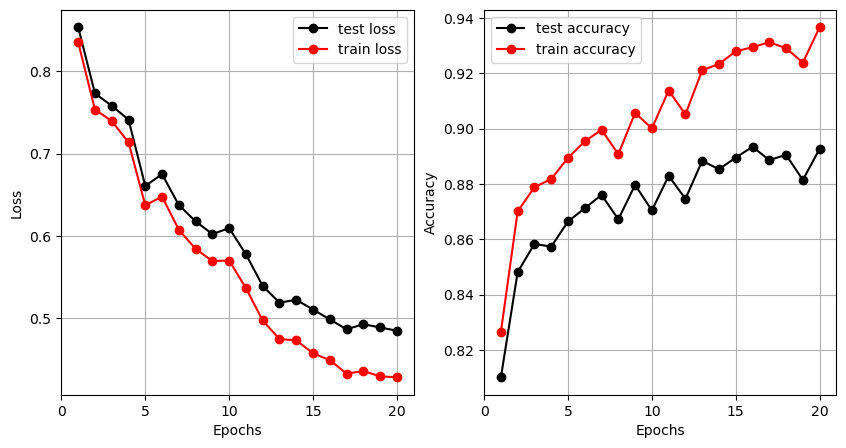

In [26]:
epochs = list(range(1,21))
fig = figure(figsize=(10,5))
ax = fig.subplots(nrows=1, ncols=2)
ax[0].plot(epochs, test_loss_of_fixed_cpu, 'k', marker='o', label="test loss")
ax[0].plot(epochs, train_loss_of_fixed_cpu, 'r', marker='o', label="train loss")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")
ax[0].set_xlim(0, 21)
ax[0].grid()
ax[0].legend()
ax[1].plot(epochs, test_acc_of_fixed_cpu, 'k', marker='o', label="test accuracy")
ax[1].plot(epochs, train_acc_of_fixed_cpu, 'r', marker='o', label="train accuracy")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")
ax[1].set_xlim(0, 21)
ax[1].legend()
ax[1].grid()
plt.show()

### Conclusions:
When the number of model parameters increases, the overfitting occurs. In our case the loss on training data decreases while the loss on testing data increases. This is the clear indication of overfitting. As we can see from the above plots, using Dropout and BatchNormalization procedures prevent overfitting.